In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Clone darknet repository

In [ ]:
%cd /content/gdrive/MyDrive/yolov4
!/usr/local/cuda/bin/nvcc --version

/content/gdrive/.shortcut-targets-by-id/1AceQcbOZK18oBycJkq_g-qOyBdoPdEgz/yolov4
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [ ]:
!nvidia-smi

Mon May 30 18:10:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!git clone https://github.com/AlexeyAB/darknet.git

## change makefile

In [ ]:
%cd darknet
import re
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile

## build

In [ ]:
!make
!chmod +x ./darknet

# Clone duckietown data

In [ ]:
%cd /content/gdrive/MyDrive/yolov4/darknet/data

In [ ]:
!git lfs install

In [ ]:
!git lfs track "*.xml"
!git add .gitattributes

In [ ]:
!git clone https://github.com/duckietown/duckietown-objdet.git

# Data preparation

import libraries

In [ ]:
import os 
from bs4 import BeautifulSoup
import xml.etree.ElementTree as ET
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np

create obj folder in darknet data file. all your training datas should be saved here later

In [ ]:
%cd /content/gdrive/MyDrive/yolov4/darknet/data
!mkdir obj

/content/gdrive/.shortcut-targets-by-id/1AceQcbOZK18oBycJkq_g-qOyBdoPdEgz/yolov4/darknet/data


In [ ]:
!ls

duckietown-objdet  labels  obj	obj.data  obj.names


set path for the each xml and image data in duckietown dataset and read name of each files.  

set directory of text file where your yolo annotation txt files will be saved later

In [ ]:
xml_path = '/content/gdrive/MyDrive/yolov4/darknet/data/duckietown-objdet/duckie_data/annotations/'
img_path = '/content/gdrive/MyDrive/yolov4/darknet/data/duckietown-objdet/duckie_data/training-images/'
txt_path = '/content/gdrive/MyDrive/yolov4/darknet/data/obj/'

In [ ]:
xml_fl = os.listdir(xml_path)
img_fl = os.listdir(img_path)

In [ ]:
len(xml_fl),len(img_fl)

(3202, 1824)

## Unique data

find unique object name and how many class indices we have

In [ ]:
num = len(xml_fl)
obj_name_list = []

In [ ]:
for i in range(num):
  with open(xml_path+xml_fl[i],'rb') as f:
    data = f.read()
  soup = BeautifulSoup(data, 'xml')
  obj = soup.find_all('object')
  for j in range(len(obj)):
    n = obj[j].find('name')
    obj_name_list = np.append(obj_name_list, n.text)

In [ ]:
unique_obj_name_list = np.unique(obj_name_list)
unique_obj_name_list, len(unique_obj_name_list)

(array(['Duckie', 'Duckiebot', 'Intersection sign', 'QR code',
        'Signal sign', 'Stop sign', 'Traffic light'], dtype='<U32'), 7)

we have 7 classes : 'Duckie', 'Duckiebot', 'Intersection sign', 'QR code', 'Signal sign', 'Stop sign', 'Traffic light'

## XML to YOLO annotation

Since we have different number of image data and annotation data, we only need to convert xml file to txt file for the data which has both image and annotation. Here I use name of the files to check if it has both image and annotation files.

In [ ]:
wo_img_fl = []
for i in range(len(img_fl)):
  wo_img_fl = np.append(wo_img_fl, os.path.splitext(img_fl[i])[0])

how to convert xml bounding box data to yolo annotation

```
bw = xmax - xmin
bh = ymax - ymin
x_center_coordinate = (xmin +(bw/2))/iw)
y_center_coordinate = (ymin +(bh/2))/ih)
yolo_width = bw/iw
yolo_height = bh/ih
```


In [ ]:
iw = 640
ih = 480
for i in range(num):
  with open(xml_path+xml_fl[i], 'r') as f:
    data = f.read()
  root = ET.XML(data)
  soup = BeautifulSoup(data,'xml')
  obj = soup.find_all('object')
  objn = len(obj)
  fn = os.path.splitext(xml_fl[i])[0]
  if len(np.argwhere(wo_img_fl == fn)) == 1:
    with open(txt_path+fn+'.txt', 'w') as f1:
      for j in range(5,objn+5):
        f1.write(str(int(np.argwhere(unique_obj_name_list == root[j][0].text)))+' ')
        bw = int(root[j][4][2].text) - int(root[j][4][0].text)
        bh = int(root[j][4][3].text) - int(root[j][4][1].text)
        f1.write(str(float((int(root[j][4][0].text)+(bw/2))/iw))+' ')
        f1.write(str(float((int(root[j][4][1].text)+(bh/2))/ih))+' ')
        f1.write(str(bw/iw)+' ')
        f1.write(str(bh/ih))
        f1.write('\n')

check

In [ ]:
ch = os.listdir(txt_path)
len(ch)

1824

# Create obj files

obj.data file has information for the training including number of classes and directories for the training datas. backup directory is where our custom model weight will be saved after training.

obj.names file has name of each classes corresponding to the class number. So for example, the model recognizes duckiebot as class number 1, so duckiebot should be written in the second order in obj.names file.

In [ ]:
obj_path =  '/content/gdrive/MyDrive/yolov4/darknet/data/'

In [ ]:
with open(obj_path+'obj.data','w')as f:
  f.write('classes = 7\n')
  f.write('train=data/train.txt\n')
  f.write('valid=data/test.txt\n')
  f.write('names=data/obj.names\n')
  f.write('backup=backup/')

In [ ]:
with open(obj_path+'obj.names','w')as f:
  for i in unique_obj_name_list:
    f.write(i+'\n')

## check files

In [ ]:
!cat /content/gdrive/MyDrive/yolov4/darknet/data/obj.data

In [ ]:
!cat /content/gdrive/MyDrive/yolov4/darknet/data/obj.names

Duckie
Duckiebot
Intersection sign
QR code
Signal sign
Stop sign
Traffic light


# Create txt files

these txt files have name of each image data with their directory. yolo model reads these files and train the files after finding them in the obj folder where all the data is saved. 

set directory

In [ ]:
d_path = '/content/gdrive/MyDrive/yolov4/darknet/data/'

split data into train and test in 9:1 ratio

In [ ]:
r = int(len(img_fl)*0.9)

directory where our custom data is located

In [ ]:
dir = 'data/obj/'

create each train.txt and test.txt file with directory of data + name of image data file 

In [ ]:
with open(d_path+'train.txt','w') as f:
  for i in range(r):
    f.write(dir+img_fl[i])
    f.write('\n')

In [ ]:
with open(d_path+'test.txt','w') as f1:
  for i in range(r,len(img_fl)):
    f1.write(dir+img_fl[i])
    f1.write('\n')

# Modify cfg file

cfg file decides the model architecture and the hyper-parameter of the model. since we are doing transfer learning, we don't need to write our own cfg file but we need to modify the existing yolov4 cfg file.


below code changes width, height, max_batches, steps, classes, and filters in the cfg file. classes equals 7 since we have 7 class labels and max_batch equals 7*20000. steps should be two numbers which are 80,90 percent of the max_batch. 


Yolo model separates one image into S*S grid and each grid detects B bounding boxes. Each bounding box detects 5 indices including confidence, bbox location(x,y coordinates), and bbox size(width, height), here bbox means bounding box. since yolov4 has 3 convolutional layers each, filters equals( number of class label + 5) * 3

In [ ]:
%cd /content/gdrive/MyDrive/yolov4/darknet/cfg

#!sed -i 's/batch=1/batch=64/g' yolov4-custom.cfg
#!sed -i 's/subdivisions=1/subdivisions=16/g' yolov4-custom.cfg
!sed -i 's/width=608/width=416/g' yolov4-custom.cfg
!sed -i 's/height=608/height=416/g' yolov4-custom.cfg
!sed -i 's/max_batches = 500500/max_batches = 14000/g' yolov4-custom.cfg
!sed -i 's/steps=400000,450000/steps=11200,12600/g' yolov4-custom.cfg
!sed -i 's/classes=80/classes=7/g' yolov4-custom.cfg
!sed -i 's/filters=256/filters=36/g' yolov4-custom.cfg

%cd ..

# Model Training

## download weight

since we are performing transfer learning, we need to download pre-trained weight

In [ ]:
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137

## training

In [ ]:
%cd /content/gdrive/MyDrive/yolov4/darknet

/content/gdrive/.shortcut-targets-by-id/1AceQcbOZK18oBycJkq_g-qOyBdoPdEgz/yolov4/darknet


In [ ]:
!chmod +x ./darknet

for the training, we need to set data file, cfg file, model weight with their directories each.

In [ ]:
!./darknet detector train data/obj.data cfg/yolov4-custom.cfg yolov4.conv.137 -dont_show -ext_output -map

Streaming output truncated to the last 5000 lines.
 total_bbox = 1147145, rewritten_bbox = 0.100859 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 139 Avg (IOU: 0.710492), count: 112, class_loss = 13.701142, iou_loss = 539.448181, total_loss = 553.149353 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 150 Avg (IOU: 0.651283), count: 48, class_loss = 9.539515, iou_loss = 36.742180, total_loss = 46.281696 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 161 Avg (IOU: 0.463464), count: 9, class_loss = 1.767203, iou_loss = 0.547123, total_loss = 2.314326 
 total_bbox = 1147314, rewritten_bbox = 0.100844 % 


 Tensor Cores are disabled until the first 3000 iterations are reached.
 (next mAP calculation at 1000 iterations) ]2;644/14000: loss=7.5 hours left=14.1
 644: 7.456522, 5.615394 avg loss, 0.000172 rate, 6.748963 seconds, 41216 images, 14.115670 hours left
Loaded: 0.000067 seconds
v3 (iou loss, Normalizer: (iou: 0.07, obj:

## performance check


In [ ]:
!./darknet detector map data/obj.data cfg/yolov4-custom.cfg /content/gdrive/MyDrive/yolov4/darknet/backup/yolov4-custom_last.weights -points 0

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   3 route  1 		                           ->  208 x 208 x  64 
   4 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   5 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   6 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   8 conv  

# test

to test the model, we need to batch and subdivision in cfg file. there's [test] section on the cfg file and the model will show an error if the values on that section is unmarked.

In [ ]:
%cd /content/gdrive/MyDrive/yolov4/darknet/cfg
!sed -i 's/batch=64/ batch=1/' yolov4-custom-test.cfg
!sed -i 's/subdivisions=16/subdivisions=1/' yolov4-custom-test.cfg
%cd ..

/content/gdrive/MyDrive/yolov4/darknet/cfg
/content/gdrive/MyDrive/yolov4/darknet


In [ ]:
%cd /content/gdrive/MyDrive/yolov4/darknet
!chmod +x ./darknet

/content/gdrive/MyDrive/yolov4/darknet


In [ ]:
#define utility function
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  #height, width = image.shape[:2]
  #resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  #plt.rcParams['figure.figsize'] = [10, 5]
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  plt.show()

as we set the fils with directories for the training, we need to set data file, cfg file, weight and image for detection. here we need to set cfg as yolov4-custom-test and custom trained weight. 

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   3 route  1 		                           ->  208 x 208 x  64 
   4 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   5 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   6 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   8 conv   

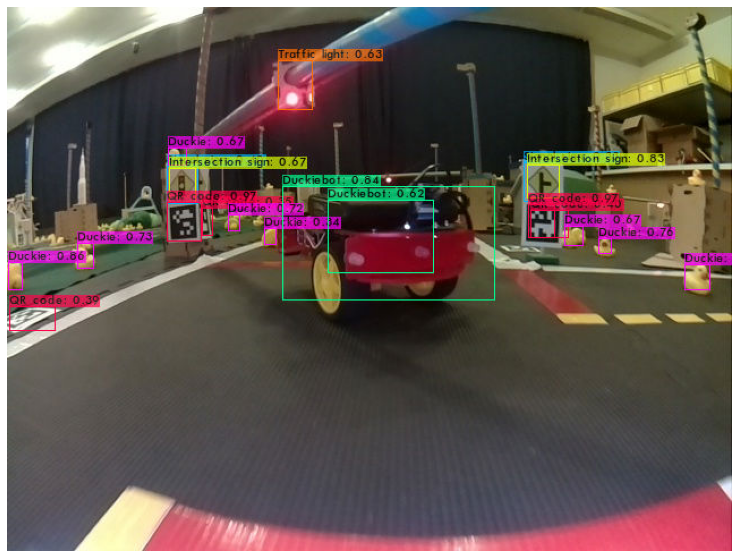

In [ ]:
!./darknet detector test data/obj.data cfg/yolov4-custom-test.cfg /content/gdrive/MyDrive/yolov4/darknet/backup/yolov4-custom_last.weights /content/gdrive/MyDrive/yolov4/darknet/data/obj/B_BR_Duckbar_frame00052.jpg -thresh 0.3 
imShow('predictions.jpg')